- 참고 
1. https://www.youtube.com/watch?v=ACmuBbuXn20

2. https://blogofth-lee.tistory.com/265

3. https://www.kaggle.com/willzy/vgg16-with-cifar10

- Torch library 정의
- cifar10 데이터 불러와서 training_set과 test_set으로 분리
- cifar10 데이터 내의 classes들 정의


In [8]:
import torch
from torch import nn as nn
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import torchvision.transforms as transforms
import torch.optim as optim


training_data = datasets.CIFAR10(
    root = "data",
    train = True,
    download = True,
    transform = ToTensor()
)
trainloader = torch.utils.data.DataLoader(training_data,
                                          batch_size = 512,
                                          shuffle = True,
                                          num_workers=0)
test_data = datasets.CIFAR10(
    root = "data",
    train=False,
    download = True,
    transform = ToTensor()
)
testloader = torch.utils.data.DataLoader(test_data,
                                          batch_size = 4,
                                          shuffle = True,
                                          num_workers=0)
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')



Files already downloaded and verified
Files already downloaded and verified


- cpu로 연산할 지 gpu로 연산할 지 설정

- 몇 개의 testset 표시

In [10]:
dataiter = iter(testloader)
images, labels = dataiter.next()
images.size()

torch.Size([4, 3, 32, 32])

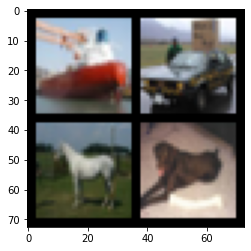

 ship   car horse   dog


In [11]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def imshow(img):
  img = img
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

dataiter = iter(testloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images, nrow=2, padding=3))

print(' '.join('%5s'%classes[labels[j]] for j in range(4)))

- 13개의 cnn 필터 + fully connected layer 3층
- 3 x 3 filter 2회와 5 x 5 filter 1회의 결과가 같음(동일한 사이즈의 특성맵 산출) 따라서 3 x 3 filter를 2회 하는게 더 나음. 
(Hyperparameter 18개 vs 25개)

In [52]:
VGG_list = [64, 64, 'M', 128, 128, 
            'M', 256, 256, 256, 
            'M', 512, 512, 512, 
            'M', 512, 512, 512, 'M'] 
# For cifar 10, modify the size of cnn.
class VGGnet(nn.Module):
  def __init__(self, in_channels, num_classes=10):
    super(VGGnet, self).__init__()
    self.in_channels = in_channels 
    # The order is very important.
    # Since after declare variables, we can use the variables
    self.conv_layers = self.create_cnn(VGG_list)
   

    self.fully_connected_layer = nn.Sequential(
        nn.Linear(512*1*1, 4096),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(4096, 4096),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(4096, num_classes)
    )
  def forward(self, x):
    x = self.conv_layers(x)
    x = x.reshape(x.shape[0], -1) 
    # For Linear part, we must flatten output of cnn.
    x = self.fully_connected_layer(x)
    return x
    
  def create_cnn(self, architecture):
    layers = []
    in_channels = self.in_channels

    for x in architecture:
      if type(x) == int:
        layers += [nn.Conv2d(in_channels = in_channels, out_channels = x,
                             kernel_size=(3,3), stride = (1, 1), padding = (1, 1))]

        in_channels = x
      elif x == "M":
        layers += [nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))]

    return nn.Sequential(*layers) # store unpacking layer list

In [53]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(12)
if device == 'cuda':
  torch.cuda.manual_seed_all(12)

In [54]:
model = VGGnet(in_channels=3, num_classes=1000).to(device)

x = torch.randn(1, 3, 32, 32)
print(model(x).shape)

torch.Size([1, 1000])
